# Neural Networks for Anomaly (Outliers) Detection

<img src='outlier_pic.jpg', width = 500, height = 600>


**JADS Career Day (June 14, 2018)**

**Practical Info: Data + Jupyter Notebook**
    
***Github**
[https://github.com/abelusha/AutoEncoders-for-Anomaly-Detection
    
http://nbviewer.jupyter.org/github/abelusha/AutoEncoders-for-Anomaly-Detection/blob/master/AutoEncoders-for-Anomaly-Detection.ipynb

**Agenda:**

- **Data Exploration & Preprocessing**
- **Model Building**
- **Model Evaluation** 
- **Model Interpretation**


In [0]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
!pip install ann_visualizer

  Created wheel for ann-visualizer: filename=ann_visualizer-2.5-cp36-none-any.whl size=4169 sha256=b32cf519206673d830cc917709826d82c02489faae43f84228cc683411380858
  Stored in directory: /root/.cache/pip/wheels/b6/b4/4e/d92f50c9c4f004cf315a0e0fcd455486bd799c50fe80cf1f5d
Successfully built ann-visualizer


In [4]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_row', None)
import matplotlib.pyplot as plt
plt.rcdefaults()
from pylab import rcParams
import seaborn as sns
%matplotlib inline
import datetime
#############
####### Deep learning libraries
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
from ann_visualizer.visualize import ann_viz
# 
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, roc_auc_score, auc,
                             precision_score, recall_score, roc_curve, precision_recall_curve,
                             precision_recall_fscore_support, f1_score,
                             precision_recall_fscore_support)
#
from IPython.display import display, Math, Latex


Using TensorFlow backend.


# Load Data

In [0]:
df = pd.read_csv('JADS_CarrerDay_Data.csv.xls',index_col=0)
df.reset_index(inplace=True, drop= True)

# Highly Imbalanced Data

In [0]:
numerical_cols = ['V_1', 'V_2', 'V_3', 'V_4', 'V_5', 'V_6', 'V_7', 'V_8', 'V_9']

In [0]:
labels = df['Label'].astype(int)
labels[labels != 0] = 1

# Data Exploration

In [0]:
x = df.Label.astype(str).unique().tolist();
y =  df.Label.value_counts().tolist();

In [0]:
sns.set(style="white", palette="muted", color_codes=True)

In [0]:
f, axes = plt.subplots(5, 2, figsize=(8,20))
sns.kdeplot(df['V_1'],ax=axes[0,0])
sns.kdeplot(df['V_2'],ax=axes[0,1])
sns.kdeplot(df['V_3'],ax=axes[1,0])
sns.kdeplot(df['V_4'],ax=axes[1,1])
sns.kdeplot(df['V_5'],ax=axes[2,0])
sns.kdeplot(df['V_6'],ax=axes[2,1])
sns.kdeplot(df['V_7'],ax=axes[3,0])
sns.kdeplot(df['V_8'],ax=axes[3,1])
sns.kdeplot(df['V_9'],ax=axes[4,0])
sns.kdeplot(df['Label'],ax=axes[4,1])


In [0]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(df.corr(),cmap="YlGnBu",annot=True)

# AutoEncoders

- Feed Forward Neural Network model for unsupervised tasks (No Lables)
- Model the identity function f(x) ≈  x (It encodes itself)
- Simple to undersatnd!
- Compress data and learn some features 

Ref:
https://probablydance.com/2016/04/30/neural-networks-are-impressively-good-at-compression/




<img src='AutoEncoders.png',>


# Reconstruction error


min $$L(x, x')  ≈ ||x - x'||^{2}$$

# Data Preprocessing 


In [11]:
RANDOM_SEED = 101

X_train, X_test = train_test_split(df, test_size=0.2, random_state = RANDOM_SEED)

X_train = X_train[X_train['Label'] == 0]
X_train = X_train.drop(['Label'], axis=1)
y_test  = X_test['Label']
X_test  = X_test.drop(['Label'], axis=1)
X_train = X_train.values
X_test  = X_test.values
print('Training data size   :', X_train.shape)
print('Validation data size :', X_test.shape)

Training data size   : (3558, 9)
Validation data size : (910, 9)


# Data Scaling

In [0]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Modeling

In [13]:
# No of Neurons in each Layer [9,6,3,2,3,6,9]
input_dim = X_train.shape[1]
encoding_dim = 6

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh",activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="tanh")(encoder)
encoder = Dense(int(2), activation="tanh")(encoder)
decoder = Dense(int(encoding_dim/ 2), activation='tanh')(encoder)
decoder = Dense(int(encoding_dim), activation='tanh')(decoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 9)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 60        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 8         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 9         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 24        
_________________________________________________________________
dense_6 (Dense)              (None, 9)                 63  

In [15]:
nb_epoch = 100
batch_size = 50
autoencoder.compile(optimizer='adam', loss='mse' )

t_ini = datetime.datetime.now()
history = autoencoder.fit(X_train_scaled, X_train_scaled,
                        epochs=nb_epoch,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.1,
                        verbose=0
                        )

t_fin = datetime.datetime.now()
print('Time to run the model: {} Sec.'.format((t_fin - t_ini).total_seconds()))



df_history = pd.DataFrame(history.history)
# validation_data=(X_test_scaled, X_test_scaled)

Time to run the model: 22.366823 Sec.


In [0]:
x=df_history.index.tolist();
trainloss=df_history['loss'].tolist()
valloss=df_history['val_loss'].tolist()

In [0]:
df_history

In [0]:
plt.figure(figsize=(20,10))
plt.plot(x,trainloss,x,valloss)
plt.legend()

# Predictions & Computing Reconstruction Error

In [18]:
predictions = autoencoder.predict(X_test_scaled)

mse = np.mean(np.power(X_test_scaled - predictions, 2), axis=1)
df_error = pd.DataFrame({'reconstruction_error': mse, 'Label': y_test}, index=y_test.index)
df_error.describe()


,reconstruction_error,Label
count,910.000000,910.000000
mean,0.007047,0.026374
std,0.008566,0.160332
min,0.000114,0.000000
25%,0.001888,0.000000
50%,0.003849,0.000000
75%,0.008333,0.000000
max,0.064540,1.000000


In [19]:
df_error.head()

,reconstruction_error,Label
1192,0.000895,0
2689,0.004476,0
2351,0.001040,1
3121,0.001433,0
4513,0.004792,0


# Model Interpretability

- Major problem of neural network models is ...?

- Contribution of Each dimension to the RE


In [0]:
# change X_tes_scaled to pandas dataframe
data_n = pd.DataFrame(X_test_scaled, index= y_test.index, columns=numerical_cols)

In [0]:
def compute_error_per_dim(point):
    
    initial_pt = np.array(data_n.loc[point,:]).reshape(1,9)
    reconstrcuted_pt = autoencoder.predict(initial_pt)
    
    return abs(np.array(initial_pt  - reconstrcuted_pt)[0])

In [48]:
df_error.query('-0.01 > reconstruction_error or reconstruction_error> 0.024').index

Int64Index([1719, 1538, 3930, 2499, 3964, 1528, 1595, 3945, 1473, 1624, 1453,
            1490, 2551, 1636, 3985, 1695, 2552, 1596, 2773, 1486, 3963, 4225,
            1447, 1398, 1469, 1630, 1459, 2143, 1489, 4220, 1448, 1638, 1470,
            1529, 1434, 1541, 2779, 1634, 1429, 2768, 3976, 2780, 1705, 3020,
            1407,   37, 2775, 1424, 1463, 2749],
           dtype='int64')

In [0]:
outliers = df_error.query('-0.01 > reconstruction_error or reconstruction_error> 0.024').index.tolist()

In [0]:
outliers

In [51]:
len(outliers)

50

In [0]:
RE_per_dim = {}
for ind in outliers:
    RE_per_dim[ind] = compute_error_per_dim(ind)
    
RE_per_dim = pd.DataFrame(RE_per_dim, index= numerical_cols).T

In [53]:
RE_per_dim.head()


,V_1,V_2,V_3,V_4,V_5,V_6,V_7,V_8,V_9
1719,0.011773,0.011710,0.067756,0.190818,0.001308,0.249307,0.139603,0.307976,0.002432
1538,0.011400,0.018504,0.038517,0.337264,0.005597,0.223613,0.148976,0.290179,0.068498
3930,0.018682,0.009196,0.155996,0.318497,0.002338,0.077072,0.190314,0.184904,0.120485
2499,0.003153,0.012736,0.119792,0.334119,0.000984,0.130576,0.161631,0.213433,0.040527
3964,0.028653,0.010022,0.178199,0.342817,0.002211,0.154786,0.176234,0.139346,0.160564


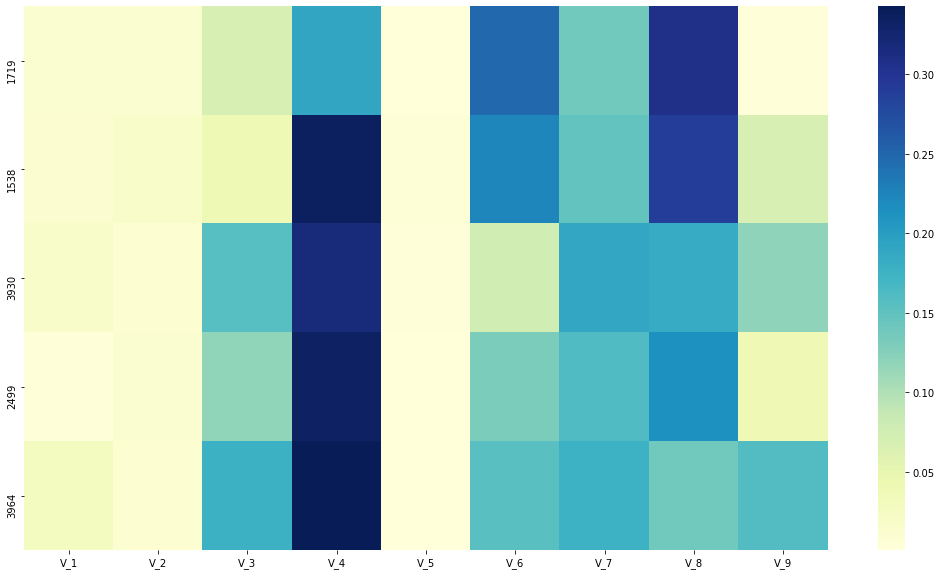

In [58]:
plt.figure(figsize=(18,10))
sns.heatmap(RE_per_dim.head(),cmap='YlGnBu')